### imports

In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import sys
import time
from functools import reduce
from IPython.display import display, Image
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc
from six.moves import cPickle as pickle
from six.moves import range
from collections import Counter

from keras.models import Sequential
from keras.layers import Dense, Activation, Convolution2D, Flatten
from keras.utils import np_utils
from keras.optimizers import SGD

%matplotlib inline

import tensorflow as tf

Using TensorFlow backend.


### parts 1-2: file loading and formatting

In [90]:
files = [
    'data_batch_1',
    'data_batch_2',
    'data_batch_3',
    'data_batch_4',
    'data_batch_5',
    'test_batch'
]

data = []
labels = []
start = time.time()
for file in files:
    with open(file, 'rb') as f:
        d = pickle.load(f, encoding='bytes')
        if file == 'test_batch':
            test_data_2d = d[b'data']
            test_labels_1d = d[b'labels']
        else:
            data.append(d[b'data'])
            labels.append(d[b'labels'])
end = time.time()
print('Time to load data: {:.3f}s\n'.format(end - start))
for i in range(len(data)):
    print('Train data {}:'.format(i+1), data[i].shape, len(labels[i]))

orig_test = test_data_2d
orig_test_labels = test_labels_1d
orig_train = train_data_2d
orig_train_labels = train_labels_1d
    
train_data_2d = reduce(lambda a,b: np.vstack((a,b)), data)
train_labels_1d = reduce(lambda a,b: a+b, labels)
print('\nMerged train data:', train_data_2d.shape, len(train_labels_1d))
print('Test data:', test_data_2d.shape, len(test_labels_1d))

Time to load data: 0.055s

Train data 1: (10000, 3072) 10000
Train data 2: (10000, 3072) 10000
Train data 3: (10000, 3072) 10000
Train data 4: (10000, 3072) 10000
Train data 5: (10000, 3072) 10000

Merged train data: (50000, 3072) 50000
Test data: (10000, 3072) 10000


### visualize a few of the images

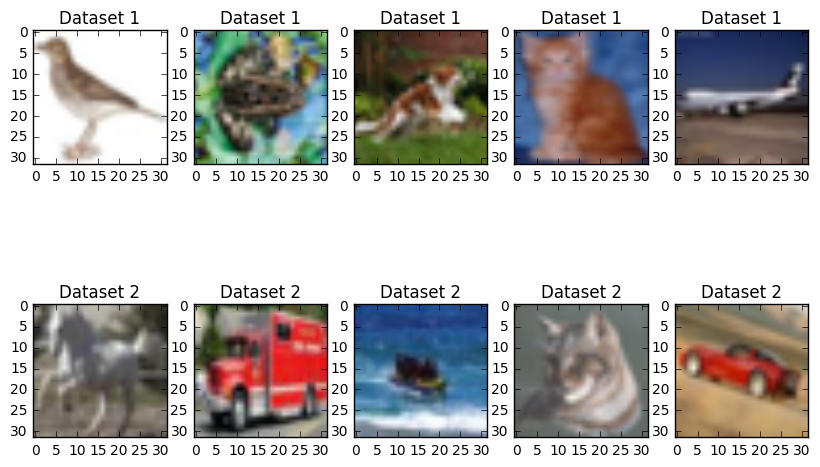

In [3]:
import matplotlib.image as mpimg

# used a batch size to speed up testing, but can easily change this to full dataset
batch_size = 1000

# random indices into the datasets so we can compare the same images across distortions
i_1 = np.random.choice(batch_size, 5)
i_2 = np.random.choice(batch_size, 5)

# basically the code from class, the images are stretched a lot but I don't think we'll
# be able to see the distortions if we view them at their actual size of 32x32 pixels
def show_images(num, i_1, dataset_1, i_2=None, dataset_2=None):
    fig1 = plt.figure(figsize=(10, 10))
    plt.gray()

    for k in range(num):
        i = i_1[k]
        if len(dataset_1.shape) == 2:
            img = np.reshape(dataset_1[i, :], (3, 32, 32)).transpose(1,2,0)
        else:
            assert(len(dataset_1.shape) == 4)
            img = dataset_1[i, :, :, :]
        imgplot1 = fig1.add_subplot(3,5,k+1)
        imgplot1.imshow(img)    
        imgplot1.set_title("Dataset 1", fontsize=12)
    
    if dataset_2 is not None:
        for k in range(num):
            i = i_2[k]
            if len(dataset_2.shape) == 2:
                img = np.reshape(dataset_2[i, :], (3, 32, 32)).transpose(1,2,0)
            else:
                assert(len(dataset_2.shape) == 4)
                img = dataset_2[i, :, :, :]
            imgplot2 = fig1.add_subplot(3,5,k+6)
            imgplot2.imshow(img)    
            imgplot2.set_title("Dataset 2", fontsize=12)
    
    plt.show()

show_images(5, i_1, train_data_2d, i_2, test_data_2d)

### dataset preprocessing

In [91]:
img_size = 32
num_labels = 10
num_channels = 3

train_labels_1d = np.array(train_labels_1d)
test_labels_1d = np.array(test_labels_1d)

# chose to go with this standardization method because it preserves the image colors, but can change it
#train_data_2d = train_data_2d / 255.0
#test_data_2d = test_data_2d / 255.0

#Trying with this method since the other one was resulting in poor accuracy
scaler = StandardScaler().fit(train_data_2d)
train_data_2d = scaler.transform(train_data_2d)
test_data_2d = scaler.transform(test_data_2d)

train_data_2d = train_data_2d.astype(np.float32)
test_data_2d = test_data_2d.astype(np.float32)

train_labels_2d = (np.arange(num_labels) == train_labels_1d[:,None]).astype(np.float32)
test_labels_2d = (np.arange(num_labels) == test_labels_1d[:,None]).astype(np.float32)

/usr/local/lib/python3.4/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


### part 3c: logistic regression

In [5]:
def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
            / predictions.shape[0])

def peek_predictions(predictions, labels):
    print('Predict[:25]:', np.argmax(predictions, 1)[:25])
    print(' Actual[:25]:', np.argmax(labels, 1)[:25])

In [6]:
def lrsgd(num_epochs, train_dataset, train_labels, test_dataset, test_labels):
    batch_size = 256

    graph = tf.Graph()
    with graph.as_default():

        # Input data, with a placeholder to feed the training data at run time.
        tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, img_size*img_size*num_channels))
        tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
        tf_test_dataset = tf.constant(test_dataset)

        # Variables.
        weights = tf.Variable(tf.truncated_normal([img_size*img_size*num_channels, num_labels]))
        biases = tf.Variable(tf.zeros([num_labels]))

        # Training computation.
        logits = tf.matmul(tf_train_dataset, weights) + biases
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))

        # Optimizer.
        optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

        # Predictions for the training, validation, and test data.
        train_prediction = tf.nn.softmax(logits)
        test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)
        
    l_array = []

    with tf.Session(graph=graph) as session:
        start = time.time()
        tf.initialize_all_variables().run()
        merged = tf.merge_all_summaries()  
        writer = tf.train.SummaryWriter("/tmp/tensorflowlogs", session.graph)
        print("Initialized")
        for epoch in range(num_epochs):

            offset = (epoch * batch_size) % (train_labels.shape[0] - batch_size)

            batch_data = train_dataset[offset:(offset + batch_size), :]
            batch_labels = train_labels[offset:(offset + batch_size), :]

            feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
            _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
            l_array.append(l)
            if (epoch % 500 == 0):
                print("Minibatch loss at epoch %d: %f" % (epoch, l))
                print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
        end = time.time()
        print('\ttraining time: {:.3f}s'.format(end - start))
        start = time.time()
        print("\nTest accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))
        # take a peek at the model's predictions
        peek_predictions(test_prediction.eval(), test_labels)
#         test_preds = pd.DataFrame(test_prediction.eval().ravel(), columns=['LR_SGD'])
        end = time.time()
        print('\taccuracy time: {:.3f}s'.format(end - start))

    return l_array

Initialized
Minibatch loss at epoch 0: 72.999039
Minibatch accuracy: 10.2%
Minibatch loss at epoch 500: 26.006348
Minibatch accuracy: 28.1%
Minibatch loss at epoch 1000: 24.560583
Minibatch accuracy: 31.6%
	training time: 6.203s

Test accuracy: 29.2%
Predict[:25]: [3 1 8 0 4 3 3 4 5 1 0 1 4 9 1 8 7 6 8 6 4 0 9 9 0]
 Actual[:25]: [3 8 8 0 6 6 1 6 3 1 0 9 5 7 9 8 5 7 8 6 7 0 4 9 5]
	accuracy time: 0.113s

Time to run: 6.356s


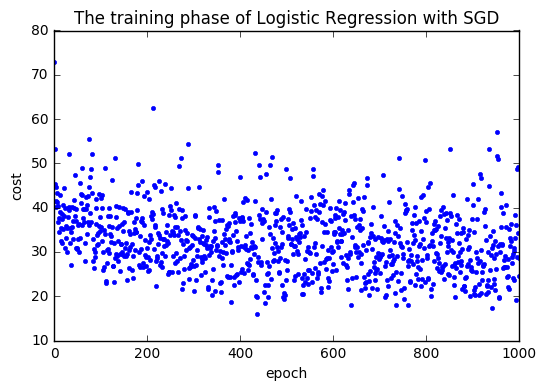

In [7]:
num_epochs = 1001
l_array = lrsgd(num_epochs, train_data_2d, train_labels_2d, test_data_2d, test_labels_2d)
plt.plot(range(num_epochs), l_array, '.')
plt.xlabel("epoch")
plt.ylabel("cost")
plt.title("The training phase of Logistic Regression with SGD")
plt.show()

### part 3a: generic deep NN

In [8]:
def weight_variable(shape):
    #initial = tf.truncated_normal(shape, stddev=0.01)
    initial = tf.truncated_normal(shape, stddev=tf.sqrt(2.0/shape[0]))
    return tf.Variable(initial)


def bias_variable(shape):
    #initial = tf.constant(0.1, shape=shape)
    initial = tf.zeros(shape)
    return tf.Variable(initial)


split_by_half = lambda x,k : int(x/2**k)

batch_size = 256
hidden_nodes = 1024
lamb_reg = 0.001
start_learning_rate = 0.05
    
def run_NN(num_epochs, name, train_dataset, train_labels, test_dataset, test_labels, k_prob=1.0):
    
    graph = tf.Graph()
    with graph.as_default():

        # Input data.
        tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, img_size*img_size*num_channels))
        tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
        tf_test_dataset = tf.constant(test_dataset)

        # Variables.
        layer1_weights = weight_variable([img_size*img_size*num_channels, hidden_nodes])
        layer1_biases = bias_variable([hidden_nodes])
        layer2_weights = weight_variable([hidden_nodes, split_by_half(hidden_nodes,1)])
        layer2_biases = bias_variable([split_by_half(hidden_nodes,1)])   
        layer3_weights = weight_variable([split_by_half(hidden_nodes,1), split_by_half(hidden_nodes,2)])
        layer3_biases = bias_variable([split_by_half(hidden_nodes,2)])    
        layer4_weights = weight_variable([split_by_half(hidden_nodes,2), num_labels])
        layer4_biases = bias_variable([num_labels])

        keep_prob = tf.placeholder("float")

        # Model with dropout
        def model(data, proba=keep_prob):
            layer1 = tf.matmul(data, layer1_weights) + layer1_biases
            hidden1 = tf.nn.dropout(tf.nn.relu(layer1), proba)  # dropout on hidden layer
            layer2 = tf.matmul(hidden1, layer2_weights) + layer2_biases  # a new hidden layer
            hidden2 = tf.nn.dropout(tf.nn.relu(layer2), proba)
            layer3 = tf.matmul(hidden2, layer3_weights) + layer3_biases
            hidden3 = tf.nn.dropout(tf.nn.relu(layer3), proba)
            return tf.matmul(hidden3, layer4_weights) + layer4_biases

        # Training computation.
        logits = model(tf_train_dataset, keep_prob)
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
        regularizers = (tf.nn.l2_loss(layer1_weights) + tf.nn.l2_loss(layer1_biases) + \
                        tf.nn.l2_loss(layer2_weights) + tf.nn.l2_loss(layer2_biases) + \
                        tf.nn.l2_loss(layer3_weights) + tf.nn.l2_loss(layer3_biases) + \
                        tf.nn.l2_loss(layer4_weights) + tf.nn.l2_loss(layer4_biases) )

        # Add the regularization term to the loss.
        #loss += lamb_reg * regularizers
        loss = tf.reduce_mean(loss + lamb_reg * regularizers)

        # Optimizer.
        # learning rate decay
        global_step = tf.Variable(0)  # count number of steps taken.

        learning_rate = tf.train.exponential_decay(start_learning_rate, global_step, 100000, 0.96, staircase=True)
        optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)

        # Predictions for the training, validation, and test data.
        train_prediction = tf.nn.softmax(logits)
        test_prediction = tf.nn.softmax(model(tf_test_dataset,1.0))
        
    with tf.Session(graph=graph) as session:
        start = time.time()
        merged = tf.merge_all_summaries()  
        writer = tf.train.SummaryWriter("tensorflowlogs", session.graph)
        tf.initialize_all_variables().run()
        print("Initialized")
        for epoch in range(num_epochs):
            offset = (epoch * batch_size) % (train_labels.shape[0] - batch_size)
            batch_data = train_dataset[offset:(offset + batch_size), :]
            batch_labels = train_labels[offset:(offset + batch_size), :]
            feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, keep_prob : k_prob}
            _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
            if (epoch % 500 == 0):
                print("Minibatch loss at epoch {}: {}".format(epoch, l))
                print("Minibatch accuracy: {:.1f}%".format(accuracy(predictions, batch_labels)))
        end = time.time()
        print('\ttraining time: {:.3f}s'.format(end - start))
        start = time.time()
        print("\nTest accuracy: {:.1f}%".format(accuracy(test_prediction.eval(), test_labels)))
        peek_predictions(test_prediction.eval(), test_labels)
        end = time.time()
        print('\taccuracy time: {:.3f}s'.format(end - start))
#         test_preds = pd.DataFrame(test_prediction.eval().ravel(), columns=['LR_SGD'])
#         test_preds[name] = test_prediction.eval().ravel()


In [9]:
run_NN(1001, "Deep_NN", train_data_2d, train_labels_2d, test_data_2d, test_labels_2d, 0.5)

Initialized
Minibatch loss at epoch 0: 5.352789878845215
Minibatch accuracy: 8.2%
Minibatch loss at epoch 500: 3.1401901245117188
Minibatch accuracy: 36.3%
Minibatch loss at epoch 1000: 3.0130624771118164
Minibatch accuracy: 37.5%
	training time: 73.715s

Test accuracy: 43.9%
Predict[:25]: [3 8 8 8 4 6 3 6 2 1 8 1 1 6 9 8 5 4 8 6 4 2 0 1 4]
 Actual[:25]: [3 8 8 0 6 6 1 6 3 1 0 9 5 7 9 8 5 7 8 6 7 0 4 9 5]
	accuracy time: 1.662s

Time to run: 75.612s


### part 3b: generic CNN

In [10]:
def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
            / predictions.shape[0])

def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.01)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

# fixed this method to reshape the data correctly and not into meaningless pixels
def reformat(dataset, labels, img_size, num_channels=1):
    dataset = dataset.reshape((-1, num_channels, img_size, img_size)).astype(np.float32).transpose(0,2,3,1)
    labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
    return dataset, labels

In [11]:
train_data_4d, train_labels_2d = reformat(train_data_2d, train_labels_1d, img_size, num_channels)
test_data_4d, test_labels_2d = reformat(test_data_2d, test_labels_1d, img_size, num_channels)
print('Training set', train_data_4d.shape, train_labels_2d.shape)
print('Test set', test_data_4d.shape, test_labels_2d.shape)

Training set (50000, 32, 32, 3) (50000, 10)
Test set (10000, 32, 32, 3) (10000, 10)


In [12]:
batch_size = 16
patch_size = 5
depth1 = 32
depth2 = 64
num_hidden = 1024

def run_CNN(num_epochs, name, train_dataset, train_labels, test_dataset, test_labels, k_prob=1.0):

    graph = tf.Graph()
    with graph.as_default():

        # Input data.
        tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, img_size, img_size, num_channels))
        tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
        tf_test_dataset = tf.constant(test_dataset)

        # Variables.
        layer1_weights = weight_variable([patch_size, patch_size, num_channels, depth1])
        layer1_biases = bias_variable([depth1])
        layer2_weights = weight_variable([patch_size, patch_size, depth1, depth2])
        layer2_biases = bias_variable([depth2])
        layer3_weights = weight_variable([img_size // 4 * img_size // 4 * depth2, num_hidden])
        layer3_biases = bias_variable([num_hidden])
        layer4_weights = weight_variable([num_hidden, num_labels])
        layer4_biases = bias_variable([num_labels])

        keep_prob = tf.placeholder(tf.float32)
        # Model with dropout
        def model(data, proba=keep_prob):
            # Convolution
            conv1 = tf.nn.conv2d(data, layer1_weights, [1, 1, 1, 1], padding='SAME') + layer1_biases
            pooled1 = tf.nn.max_pool(tf.nn.relu(conv1), ksize=[1, 2, 2, 1],
                            strides=[1, 2, 2, 1], padding='SAME')
            # Convolution
            conv2 = tf.nn.conv2d(pooled1, layer2_weights, [1, 1, 1, 1], padding='SAME') + layer2_biases
            pooled2 = tf.nn.max_pool(tf.nn.relu(conv2), ksize=[1, 2, 2, 1],
                            strides=[1, 2, 2, 1], padding='SAME')
            # Fully Connected Layer
            shape = pooled2.get_shape().as_list()
            reshape = tf.reshape(pooled2, [shape[0], shape[1] * shape[2] * shape[3]])
            full3 = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
            # Dropout
            full3 = tf.nn.dropout(full3, proba)
            return tf.matmul(full3, layer4_weights) + layer4_biases

        # Training computation.
        logits = model(tf_train_dataset, keep_prob)
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))

        # Optimizer.
        optimizer = tf.train.AdamOptimizer(1e-4).minimize(loss)

        # Predictions for the training, validation, and test data.
        train_prediction = tf.nn.softmax(logits)
        test_prediction = tf.nn.softmax(model(tf_test_dataset,1.0))
    
    with tf.Session(graph=graph) as session:
        start = time.time()
        merged = tf.merge_all_summaries()  
        writer = tf.train.SummaryWriter("tensorflowlogs", session.graph)
        tf.initialize_all_variables().run()
        print("Initialized")
        for epoch in range(num_epochs):
            offset = (epoch * batch_size) % (train_labels.shape[0] - batch_size)
            batch_data = train_dataset[offset:(offset + batch_size), :]
            batch_labels = train_labels[offset:(offset + batch_size), :]
            feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, keep_prob : k_prob}
            _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
            if (epoch % 500 == 0):
                print("Minibatch loss at epoch {}: {}".format(epoch, l))
                print("Minibatch accuracy: {:.1f}%".format(accuracy(predictions, batch_labels)))
        end = time.time()
        print('\ttraining time: {:.3f}s'.format(end - start))
        start = time.time()
        print("\nTest accuracy: {:.1f}%".format(accuracy(test_prediction.eval(), test_labels)))
        peek_predictions(test_prediction.eval(), test_labels)
        end = time.time()
        print('\taccuracy time: {:.3f}s'.format(end - start))
#         test_preds = pd.DataFrame(test_prediction.eval().ravel(), columns=['LR_SGD'])
#         test_preds[name] = test_prediction.eval().ravel()


In [13]:
run_CNN(1001, "CNN", train_data_4d, train_labels_2d, test_data_4d, test_labels_2d, 0.5)

Initialized
Minibatch loss at epoch 0: 2.309711456298828
Minibatch accuracy: 6.2%
Minibatch loss at epoch 500: 1.8557120561599731
Minibatch accuracy: 12.5%
Minibatch loss at epoch 1000: 1.888847827911377
Minibatch accuracy: 18.8%
	training time: 49.049s

Test accuracy: 42.3%
Predict[:25]: [3 8 8 8 4 6 3 6 5 1 0 9 5 1 1 5 5 3 8 6 7 0 0 1 2]
 Actual[:25]: [3 8 8 0 6 6 1 6 3 1 0 9 5 7 9 8 5 7 8 6 7 0 4 9 5]
	accuracy time: 11.919s

Time to run: 61.232s


### part 4: subdividing training dataset

Now we're going to try varying the size of the training set.

In [14]:
c = Counter(train_labels_1d)
for i in range(num_labels):
    print(i, c[i])
#We have 5,000 of each label in our data

bucket = []
for i in range(0,10):
    bucket.append([z for z, x in enumerate(train_labels_1d) if x == i])
    print(i, bucket[i][:20])
#This finds all the indexes for each value in our training data, and stores them into the 'bucket' list of lists
print(len(train_labels_1d), train_labels_1d[:35])

0 5000
1 5000
2 5000
3 5000
4 5000
5 5000
6 5000
7 5000
8 5000
9 5000
0 [29, 30, 35, 49, 77, 93, 115, 116, 129, 165, 179, 185, 189, 199, 213, 220, 223, 233, 264, 276]
1 [4, 5, 32, 44, 45, 46, 60, 61, 64, 65, 75, 79, 94, 96, 97, 99, 105, 112, 119, 126]
2 [6, 13, 18, 24, 41, 42, 47, 48, 54, 55, 57, 63, 90, 108, 120, 121, 123, 138, 144, 171]
3 [9, 17, 21, 26, 33, 36, 38, 39, 59, 74, 78, 80, 91, 101, 141, 142, 150, 159, 169, 174]
4 [3, 10, 20, 28, 34, 58, 66, 82, 86, 89, 98, 130, 145, 149, 153, 158, 162, 175, 180, 247]
5 [27, 40, 51, 56, 70, 81, 83, 107, 128, 148, 156, 157, 167, 173, 177, 182, 183, 195, 198, 215]
6 [0, 19, 22, 23, 25, 72, 95, 103, 104, 117, 124, 125, 132, 143, 151, 154, 164, 187, 200, 204]
7 [7, 11, 12, 37, 43, 52, 68, 73, 84, 85, 87, 113, 114, 131, 133, 152, 163, 172, 178, 181]
8 [8, 62, 69, 92, 100, 106, 111, 135, 139, 155, 161, 170, 190, 192, 193, 216, 221, 222, 240, 244]
9 [1, 2, 14, 15, 16, 31, 50, 53, 67, 71, 76, 88, 102, 109, 110, 118, 122, 127, 146, 147]
50000 [6 9

In [15]:
t1 = []
l1 = []

t2 = []
l2 = []

t3 = []
l3 = []
#Create our training and label subsets

c12 = []
c13 = []
c23 = []
#Create our combined training sets

v12 = []
v13 = []
v23 = []
#Create our combined label sets

for i in range(0,10):
    t1.extend(bucket[i][:1700])
    l1.extend(bucket[i][:1700])
    
    t2.extend(bucket[i][1701:3400])
    l2.extend(bucket[i][1701:3400])
    
    t3.extend(bucket[i][3401:5000])
    l3.extend(bucket[i][3401:5000])
    #Now we append those index subsets together. This is for our basic sets.
    
    c12.extend(bucket[i][:3400])
    c13.extend(bucket[i][:1700])
    c13.extend(bucket[i][3401:5000])
    c23.extend(bucket[i][1701:5000])
    
    v12.extend(bucket[i][:3400])
    v13.extend(bucket[i][:1700])
    v13.extend(bucket[i][3401:5000])
    v23.extend(bucket[i][1701:5000])
    #Now for the combined sets

t1 = train_data_2d[np.array(t1)]
l1 = np.array([train_labels_1d[i] for i in l1])
l1 = (np.arange(num_labels) == l1[:,None]).astype(np.float32)
indices = np.array(range(l1.shape[0]))
np.random.shuffle(indices)  # need to shuffle these datasets otherwise they are sorted by label
t1 = t1[indices]
l1 = l1[indices]

t2 = train_data_2d[np.array(t2)]
l2 = np.array([train_labels_1d[i] for i in l2])
l2 = (np.arange(num_labels) == l2[:,None]).astype(np.float32)
indices = np.array(range(l2.shape[0]))
np.random.shuffle(indices)  # need to shuffle these datasets otherwise they are sorted by label
t2 = t2[indices]
l2 = l2[indices]

t3 = train_data_2d[np.array(t3)]
l3 = np.array([train_labels_1d[i] for i in l3])
l3 = (np.arange(num_labels) == l3[:,None]).astype(np.float32)
indices = np.array(range(l3.shape[0]))
np.random.shuffle(indices)  # need to shuffle these datasets otherwise they are sorted by label
t3 = t3[indices]
l3 = l3[indices]
#And now we convert them so they're actually lists of values rather than indices
#Above is simple sets

c12 = train_data_2d[np.array(c12)]
v12 = np.array([train_labels_1d[i] for i in v12])
v12 = (np.arange(num_labels) == v12[:,None]).astype(np.float32)
indices = np.array(range(v12.shape[0]))
np.random.shuffle(indices)  # need to shuffle these datasets otherwise they are sorted by label
c12 = c12[indices]
v12 = v12[indices]

c13 = train_data_2d[np.array(c13)]
v13 = np.array([train_labels_1d[i] for i in v13])
v13 = (np.arange(num_labels) == v13[:,None]).astype(np.float32)
indices = np.array(range(v13.shape[0]))
np.random.shuffle(indices)  # need to shuffle these datasets otherwise they are sorted by label
c13 = c13[indices]
v13 = v13[indices]

c23 = train_data_2d[np.array(c23)]
v23 = np.array([train_labels_1d[i] for i in v23])
v23 = (np.arange(num_labels) == v23[:,None]).astype(np.float32)
indices = np.array(range(v23.shape[0]))
np.random.shuffle(indices)  # need to shuffle these datasets otherwise they are sorted by label
c23 = c23[indices]
v23 = v23[indices]

Now we've split our data into the following sets:

T1/T2/T3: Training data, in thirds, of the original set- each containing the same number of each class
C12/C13/C23: Combined versions of the above three sets. We've already used ALL the data in a run, so there's no point to C123

In [16]:
num_epochs = 1001
l_array = lrsgd(num_epochs, t1, l1, test_data_2d, test_labels_2d)

Initialized
Minibatch loss at epoch 0: 73.795654
Minibatch accuracy: 13.3%
Minibatch loss at epoch 500: 33.848381
Minibatch accuracy: 26.2%
Minibatch loss at epoch 1000: 29.353848
Minibatch accuracy: 27.3%
	training time: 5.736s

Test accuracy: 29.0%
Predict[:25]: [3 9 0 0 4 3 3 4 5 9 0 9 4 4 1 0 0 6 8 4 4 0 4 9 7]
 Actual[:25]: [3 8 8 0 6 6 1 6 3 1 0 9 5 7 9 8 5 7 8 6 7 0 4 9 5]
	accuracy time: 0.122s

Time to run: 5.904s


In [17]:
num_epochs = 1001
l_array = lrsgd(num_epochs, c12, v12, test_data_2d, test_labels_2d)

Initialized
Minibatch loss at epoch 0: 62.716873
Minibatch accuracy: 9.0%
Minibatch loss at epoch 500: 31.821184
Minibatch accuracy: 31.2%
Minibatch loss at epoch 1000: 20.243752
Minibatch accuracy: 27.0%
	training time: 5.663s

Test accuracy: 25.6%
Predict[:25]: [3 9 9 5 4 6 3 4 5 1 0 9 4 4 9 0 7 5 9 4 4 5 8 1 5]
 Actual[:25]: [3 8 8 0 6 6 1 6 3 1 0 9 5 7 9 8 5 7 8 6 7 0 4 9 5]
	accuracy time: 0.113s

Time to run: 5.818s


Above is our results for the logistic regression- train time on the smaller sets is incredibly fast, but accuracy is about on par with the full dataset.

In [18]:
run_NN(1001, "Deep_NN", t1, l1, test_data_2d, test_labels_2d, 0.5)

Initialized
Minibatch loss at epoch 0: 2.4601330757141113
Minibatch accuracy: 6.2%
Minibatch loss at epoch 500: 2.231961965560913
Minibatch accuracy: 12.5%
Minibatch loss at epoch 1000: 2.1064817905426025
Minibatch accuracy: 25.0%
	training time: 16.405s

Test accuracy: 31.7%
Predict[:25]: [5 8 8 8 4 6 5 4 5 9 0 1 4 5 9 8 5 1 8 4 7 2 0 1 4]
 Actual[:25]: [3 8 8 0 6 6 1 6 3 1 0 9 5 7 9 8 5 7 8 6 7 0 4 9 5]
	accuracy time: 1.765s

Time to run: 18.336s


In [19]:
run_NN(1001, "Deep_NN", c12, v12, test_data_2d, test_labels_2d, 0.5)

Initialized
Minibatch loss at epoch 0: 2.4576807022094727
Minibatch accuracy: 6.2%
Minibatch loss at epoch 500: 1.9329973459243774
Minibatch accuracy: 31.2%
Minibatch loss at epoch 1000: 1.9177911281585693
Minibatch accuracy: 18.8%
	training time: 16.787s

Test accuracy: 33.9%
Predict[:25]: [5 1 8 8 5 6 5 2 5 1 8 9 5 5 9 5 5 7 8 5 9 0 0 9 7]
 Actual[:25]: [3 8 8 0 6 6 1 6 3 1 0 9 5 7 9 8 5 7 8 6 7 0 4 9 5]
	accuracy time: 1.653s

Time to run: 18.610s


The Generic Deepnet is getting accuracy levels with the subsets about 2/3 of the accuracy level of the full dataset, but the accuracy didn't change much when we went from 1/3 to 2/3 full dataset, which is odd. The 2/3 dataset accuracy is a tad higher than the 1/3 dataset accuracy but well within the range of variation we've seen empirically.

In [20]:
t1, _ = reformat(t1, train_labels_1d, img_size, num_channels)
c12, _ = reformat(c12, test_labels_1d, img_size, num_channels)
print(t1.shape, l1.shape)
print(c12.shape, v12.shape)

(17000, 32, 32, 3) (17000, 10)
(34000, 32, 32, 3) (34000, 10)


In [21]:
run_CNN(1001, "CNN", t1, l1, test_data_4d, test_labels_2d, 0.5)

Initialized
Minibatch loss at epoch 0: 2.298806667327881
Minibatch accuracy: 12.5%
Minibatch loss at epoch 500: 2.228367328643799
Minibatch accuracy: 12.5%
Minibatch loss at epoch 1000: 1.776007890701294
Minibatch accuracy: 37.5%
	training time: 49.115s

Test accuracy: 41.9%
Predict[:25]: [3 8 8 8 4 6 3 6 5 1 8 9 3 7 9 2 3 3 8 7 7 7 0 9 4]
 Actual[:25]: [3 8 8 0 6 6 1 6 3 1 0 9 5 7 9 8 5 7 8 6 7 0 4 9 5]
	accuracy time: 12.089s

Time to run: 61.506s


In [22]:
run_CNN(1001, "CNN", c12, v12, test_data_4d, test_labels_2d, 0.5)

Initialized
Minibatch loss at epoch 0: 2.2914927005767822
Minibatch accuracy: 18.8%
Minibatch loss at epoch 500: 1.7210469245910645
Minibatch accuracy: 31.2%
Minibatch loss at epoch 1000: 1.668547511100769
Minibatch accuracy: 37.5%
	training time: 48.644s

Test accuracy: 43.9%
Predict[:25]: [3 1 8 8 6 1 3 6 5 1 0 1 5 1 1 2 5 9 8 6 7 0 0 9 7]
 Actual[:25]: [3 8 8 0 6 6 1 6 3 1 0 9 5 7 9 8 5 7 8 6 7 0 4 9 5]
	accuracy time: 12.604s

Time to run: 61.497s


The CNN's accuracy, like that of the logistic regression, does not appear to be greatly impacted by subsetting the data.

### part 5: applying distortions to test dataset

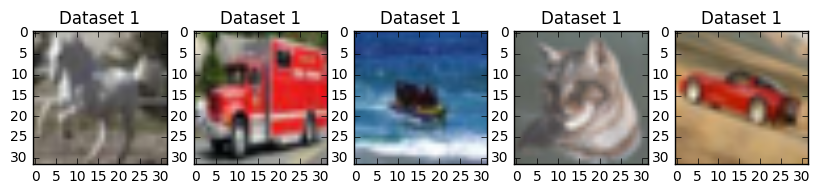

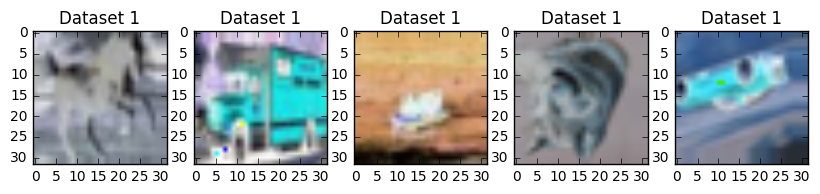

Time to run: 1.853s


In [23]:
from keras.preprocessing.image import ImageDataGenerator

# at some point when it's not 3am here I'll move this code down to after the reformatting
# but I couldn't get it to work earlier
temp_data = orig_test.reshape(-1,3,32,32).transpose(0,2,3,1)
temp_labels = np_utils.to_categorical(test_labels_1d, 10)

show_images(5, i_2, temp_data)

start = time.time()
# there are many options for the distortions we can do with this image processing tool
datagen = ImageDataGenerator(
    width_shift_range=.1,   # randomly shifts some images 10% horizontally
    height_shift_range=.1,  # randomly shifts some images 10% vertically
    horizontal_flip=True,   # randomly flips some images horizontally
    vertical_flip=True      # randomly flips some images vertically
)
# datagen.fit(temp_data, seed=25)  # this only matters if we're using other specific parameters
for distorted_test_data, distorted_test_labels in datagen.flow(temp_data, temp_labels,
                                                            shuffle=False,
                                                            batch_size=len(temp_labels),
                                                            seed=25):
    break  # it's an infinite generator and we just want 1 application of the distortions
end=time.time()

show_images(5, i_2, distorted_test_data)
print('Time to run: {:.3f}s'.format(end - start))

In [24]:
#Apply our scaler to our temp data
temp_data_2d = scaler.transform(orig_test)
temp_data_2d = temp_data_2d.astype(np.float32)

/usr/local/lib/python3.4/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


In [25]:
temp_data_4d, temp_labels_2d = reformat(temp_data_2d, test_labels_1d, img_size, num_channels)
#Prepare data for CNN

In [26]:
num_epochs = 1001
l_array = lrsgd(num_epochs, train_data_2d, train_labels_2d, temp_data_2d, test_labels_2d)

Initialized
Minibatch loss at epoch 0: 61.937759
Minibatch accuracy: 12.9%
Minibatch loss at epoch 500: 45.383743
Minibatch accuracy: 25.0%
Minibatch loss at epoch 1000: 24.650425
Minibatch accuracy: 30.9%
	training time: 5.677s

Test accuracy: 27.8%
Predict[:25]: [3 1 8 0 4 3 3 3 0 1 0 1 3 3 1 8 7 6 8 3 4 0 3 1 7]
 Actual[:25]: [3 8 8 0 6 6 1 6 3 1 0 9 5 7 9 8 5 7 8 6 7 0 4 9 5]
	accuracy time: 0.117s

Time to run: 5.834s


Slight accuracy loss, but nothing severe for this model

In [27]:
run_NN(1001, "Deep_NN", train_data_2d, train_labels_2d, temp_data_2d, test_labels_2d, 0.5)

Initialized
Minibatch loss at epoch 0: 2.452683210372925
Minibatch accuracy: 25.0%
Minibatch loss at epoch 500: 2.066023111343384
Minibatch accuracy: 25.0%
Minibatch loss at epoch 1000: 2.224296808242798
Minibatch accuracy: 25.0%
	training time: 16.848s

Test accuracy: 34.1%
Predict[:25]: [3 8 8 0 2 6 3 2 2 9 0 1 1 1 1 8 5 3 8 6 9 2 0 1 2]
 Actual[:25]: [3 8 8 0 6 6 1 6 3 1 0 9 5 7 9 8 5 7 8 6 7 0 4 9 5]
	accuracy time: 1.669s

Time to run: 18.736s


Surprisingly stable all things considered. Significant drop- something like 15% but not as bad as I initially expected

In [28]:
run_CNN(1001, "CNN", train_data_4d, train_labels_2d, temp_data_4d, temp_labels_2d, 0.5)

Initialized
Minibatch loss at epoch 0: 2.3136086463928223
Minibatch accuracy: 6.2%
Minibatch loss at epoch 500: 1.8870553970336914
Minibatch accuracy: 25.0%
Minibatch loss at epoch 1000: 1.8790740966796875
Minibatch accuracy: 25.0%
	training time: 49.153s

Test accuracy: 41.8%
Predict[:25]: [3 8 8 8 4 6 3 6 5 1 0 9 3 1 1 5 5 3 8 6 7 0 0 1 2]
 Actual[:25]: [3 8 8 0 6 6 1 6 3 1 0 9 5 7 9 8 5 7 8 6 7 0 4 9 5]
	accuracy time: 21.547s

Time to run: 70.940s


Not a lot of accuray decrease- CNN seems to be the most robust

### Part 6: Hyperparameter Comparison
1. CNN vs deepNN || 2. order of pooling/convolution in CNN
1. dropout || 2. normalization? || if time, 3. GD optimization - momentum, adagrad, etc.

_______________________
Deep Neural Network vs CNN

Speed + Accuracy comparison

Hyperparameters: Dropout, Epochs

In [29]:
run_NN(1001, "Deep_NN", train_data_2d, train_labels_2d, test_data_2d, test_labels_2d, 0.95)

Initialized
Minibatch loss at epoch 0: 2.4524612426757812
Minibatch accuracy: 25.0%
Minibatch loss at epoch 500: 2.1366994380950928
Minibatch accuracy: 18.8%
Minibatch loss at epoch 1000: 2.013216257095337
Minibatch accuracy: 25.0%
	training time: 16.740s

Test accuracy: 35.9%
Predict[:25]: [3 8 8 0 2 6 3 2 5 1 8 9 3 6 9 8 3 3 8 7 7 0 0 9 7]
 Actual[:25]: [3 8 8 0 6 6 1 6 3 1 0 9 5 7 9 8 5 7 8 6 7 0 4 9 5]
	accuracy time: 1.721s

Time to run: 18.628s


In [30]:
run_NN(1001, "Deep_NN", train_data_2d, train_labels_2d, test_data_2d, test_labels_2d, 0.25)

Initialized
Minibatch loss at epoch 0: 2.4529056549072266
Minibatch accuracy: 12.5%
Minibatch loss at epoch 500: 2.010465145111084
Minibatch accuracy: 18.8%
Minibatch loss at epoch 1000: 2.4844970703125
Minibatch accuracy: 18.8%
	training time: 16.703s

Test accuracy: 22.5%
Predict[:25]: [7 9 0 0 7 7 7 7 7 9 0 1 7 3 9 0 7 7 9 6 7 0 0 1 7]
 Actual[:25]: [3 8 8 0 6 6 1 6 3 1 0 9 5 7 9 8 5 7 8 6 7 0 4 9 5]
	accuracy time: 1.645s

Time to run: 18.520s


Deep NN at different dropout levels- we see that the higher dropout value leads to higher accuracy, but at the cost of increased time to run. Still, the tradeoff seems pretty good- at least, at this level. Both of these values are lower than the base 0.5 dropout we tested earlier.

In [31]:
run_CNN(1001, "CNN", train_data_4d, train_labels_2d, test_data_4d, test_labels_2d, 0.95)

Initialized
Minibatch loss at epoch 0: 2.309889078140259
Minibatch accuracy: 0.0%
Minibatch loss at epoch 500: 1.754915714263916
Minibatch accuracy: 37.5%
Minibatch loss at epoch 1000: 1.786933422088623
Minibatch accuracy: 37.5%
	training time: 46.513s

Test accuracy: 43.5%
Predict[:25]: [3 8 8 8 2 6 3 6 5 1 0 9 3 1 1 5 5 3 8 6 7 0 0 1 2]
 Actual[:25]: [3 8 8 0 6 6 1 6 3 1 0 9 5 7 9 8 5 7 8 6 7 0 4 9 5]
	accuracy time: 20.193s

Time to run: 67.009s


In [32]:
run_CNN(1001, "CNN", train_data_4d, train_labels_2d, test_data_4d, test_labels_2d, 0.25)

Initialized
Minibatch loss at epoch 0: 2.3214616775512695
Minibatch accuracy: 12.5%
Minibatch loss at epoch 500: 2.0121307373046875
Minibatch accuracy: 6.2%
Minibatch loss at epoch 1000: 1.8612990379333496
Minibatch accuracy: 37.5%
	training time: 49.056s

Test accuracy: 40.4%
Predict[:25]: [3 8 8 8 4 6 3 6 5 8 0 9 5 1 1 2 5 3 8 6 7 0 0 1 4]
 Actual[:25]: [3 8 8 0 6 6 1 6 3 1 0 9 5 7 9 8 5 7 8 6 7 0 4 9 5]
	accuracy time: 14.027s

Time to run: 63.333s


CNN at different dropouts. Slightly higher accuracy with the higher dropout- at the expense of some extra time.

In [33]:
run_NN(501, "Deep_NN", train_data_2d, train_labels_2d, test_data_2d, test_labels_2d, 0.75)

Initialized
Minibatch loss at epoch 0: 2.452548027038574
Minibatch accuracy: 6.2%
Minibatch loss at epoch 500: 2.148603916168213
Minibatch accuracy: 12.5%
	training time: 8.625s

Test accuracy: 25.4%
Predict[:25]: [6 8 8 0 6 6 6 6 2 8 0 9 1 1 8 0 3 6 8 6 6 0 8 9 6]
 Actual[:25]: [3 8 8 0 6 6 1 6 3 1 0 9 5 7 9 8 5 7 8 6 7 0 4 9 5]
	accuracy time: 1.672s

Time to run: 10.459s


In [34]:
run_NN(2001, "Deep_NN", train_data_2d, train_labels_2d, test_data_2d, test_labels_2d, 0.75)

Initialized
Minibatch loss at epoch 0: 2.457134485244751
Minibatch accuracy: 25.0%
Minibatch loss at epoch 500: 2.1210432052612305
Minibatch accuracy: 12.5%
Minibatch loss at epoch 1000: 2.072718381881714
Minibatch accuracy: 31.2%
Minibatch loss at epoch 1500: 1.3063265085220337
Minibatch accuracy: 50.0%
Minibatch loss at epoch 2000: 1.8713197708129883
Minibatch accuracy: 43.8%
	training time: 34.037s

Test accuracy: 41.7%
Predict[:25]: [3 8 8 8 4 6 3 6 5 1 8 9 1 7 9 8 5 7 8 7 4 0 0 9 7]
 Actual[:25]: [3 8 8 0 6 6 1 6 3 1 0 9 5 7 9 8 5 7 8 6 7 0 4 9 5]
	accuracy time: 1.679s

Time to run: 35.932s


Deep NN at different epoch levels. Large speed differential here- over 3x the speed, but accuracy almost doubled.

In [35]:
run_CNN(501, "CNN", train_data_4d, train_labels_2d, test_data_4d, test_labels_2d, 0.75)

Initialized
Minibatch loss at epoch 0: 2.3165066242218018
Minibatch accuracy: 0.0%
Minibatch loss at epoch 500: 1.8303250074386597
Minibatch accuracy: 31.2%
	training time: 22.581s

Test accuracy: 35.6%
Predict[:25]: [3 9 8 8 6 6 3 6 5 8 0 9 6 1 1 7 5 3 9 6 7 0 0 6 7]
 Actual[:25]: [3 8 8 0 6 6 1 6 3 1 0 9 5 7 9 8 5 7 8 6 7 0 4 9 5]
	accuracy time: 31.363s

Time to run: 54.211s


In [36]:
run_CNN(2001, "CNN", train_data_4d, train_labels_2d, test_data_4d, test_labels_2d, 0.75)

Initialized
Minibatch loss at epoch 0: 2.3061270713806152
Minibatch accuracy: 12.5%
Minibatch loss at epoch 500: 1.7991409301757812
Minibatch accuracy: 31.2%
Minibatch loss at epoch 1000: 1.8117012977600098
Minibatch accuracy: 25.0%
Minibatch loss at epoch 1500: 0.9543960690498352
Minibatch accuracy: 68.8%
Minibatch loss at epoch 2000: 1.4149363040924072
Minibatch accuracy: 56.2%
	training time: 103.603s

Test accuracy: 49.4%
Predict[:25]: [3 8 8 8 6 6 3 6 5 1 8 9 7 7 9 8 5 9 8 6 7 0 2 9 4]
 Actual[:25]: [3 8 8 0 6 6 1 6 3 1 0 9 5 7 9 8 5 7 8 6 7 0 4 9 5]
	accuracy time: 26.015s

Time to run: 129.872s


CNN at different epoch levels. Here we're seeing vast changes in training time- but with admittedly significance accuracy jumps. Still, it seems that the ratio is lopsided- on gigantic datasets it might be a poor idea altogether.

In [ ]:
num_samples = 5  # arbitrary, just depends on how many datapoints we want
num_tests = 3  # right now we're comparing CNN vs deepNN and CNN vs reordering pooling/convolutions CNN,
               # can use same base CNN for both to save time
keep_probs = [0.1, 0.25, 0.5, 0.67, 0.9]
results = np.zeros((num_samples, len(keep_probs), num_tests))
for i in range(num_samples):
    for j, kp in enumerate(keep_probs):
        # test CNN at varying dropout rates
#         results[i,j,0] = whatever the result is
        # test deepNN at varying dropout rates
#         results[i,j,1] = whatever the result is
        # test CNN with reordered pooling/convolution layers at varying dropout rates
#         results[i,j,2] = whatever the result is

# do some plot with the results

In [ ]:
# same as above, but instead of array of keep_probs, we'll normalize the data 3-4 different ways
# and run the same series of tests
# for example,
#   a) standardScaler method
#   b) simple divide by 255 method
#   c) keras featurewise normalization
#   d) keras samplewise normalization (i don't actually know when anyone would want this)

# -----------------------------Problem 7-------------------------------------------

We're seeing gains for both dropout and epoch size- with the CNN generally outperforming the NN. As a result, I believe we should focus on the CNN specifically.

Ideas:

1. Change Gradient Descent Optimization method
2. High epoch size, high Dropout
3. Artificially inflate the dataset size by adding distorted data set to original?
4. Ensemble method! Create a logistic regression for every outcome, then incorporate them as inputs to a Neural Net
-> Other types of ensembles work too. Neural nets that feed into each other?
5. Experiment with activation function

## Things I've tried

1. Adadelta Gradient Descent
2. Learning rate variation (0.2 - 0.0001)
3. Dropout levels (0.5-0.95)

#### Experiment with optimization here

In [82]:
def run_seven(num_epochs, name, train_dataset, train_labels, test_dataset, test_labels, k_prob=1.0):

    batch_size = 16
    patch_size = 5
    depth1 = 32
    depth2 = 64
    num_hidden = 2048 #Original 1024
    learning_rate = 0.1    

    graph = tf.Graph()
    with graph.as_default():

        # Input data.
        tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, img_size, img_size, num_channels))
        tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
        tf_test_dataset = tf.constant(test_dataset)

        # Variables.
        layer1_weights = weight_variable([patch_size, patch_size, num_channels, depth1])
        layer1_biases = bias_variable([depth1])
        layer2_weights = weight_variable([patch_size, patch_size, depth1, depth2])
        layer2_biases = bias_variable([depth2])
        layer3_weights = weight_variable([img_size // 4 * img_size // 4 * depth2, num_hidden])
        layer3_biases = bias_variable([num_hidden])
        layer4_weights = weight_variable([num_hidden, num_labels])
        layer4_biases = bias_variable([num_labels])

        keep_prob = tf.placeholder(tf.float32)
        # Model with dropout
        def model(data, proba=keep_prob):
            # Convolution
            conv1 = tf.nn.conv2d(data, layer1_weights, [1, 1, 1, 1], padding='SAME') + layer1_biases
            pooled1 = tf.nn.max_pool(tf.nn.relu(conv1), ksize=[1, 2, 2, 1],
                            strides=[1, 2, 2, 1], padding='SAME')
            # Convolution
            conv2 = tf.nn.conv2d(pooled1, layer2_weights, [1, 1, 1, 1], padding='SAME') + layer2_biases
            pooled2 = tf.nn.max_pool(tf.nn.relu(conv2), ksize=[1, 2, 2, 1],
                            strides=[1, 2, 2, 1], padding='SAME')
            # Fully Connected Layer
            shape = pooled2.get_shape().as_list()
            reshape = tf.reshape(pooled2, [shape[0], shape[1] * shape[2] * shape[3]])
            full3 = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
            # Dropout
            full3 = tf.nn.dropout(full3, proba)
            return tf.matmul(full3, layer4_weights) + layer4_biases

        # Training computation.
        logits = model(tf_train_dataset, keep_prob)
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
        
        # Optimizer.
        optimizer = tf.train.AdamOptimizer(1e-4).minimize(loss)
        #optimizer = tf.train.AdadeltaOptimizer(learning_rate).minimize(loss)
        
        # Predictions for the training, validation, and test data.
        train_prediction = tf.nn.softmax(logits)
        test_prediction = tf.nn.softmax(model(tf_test_dataset,1.0))
    
    with tf.Session(graph=graph) as session:
        start = time.time()
        merged = tf.merge_all_summaries()  
        writer = tf.train.SummaryWriter("tensorflowlogs", session.graph)
        tf.initialize_all_variables().run()
        print("Initialized")
        for epoch in range(num_epochs):
            offset = (epoch * batch_size) % (train_labels.shape[0] - batch_size)
            batch_data = train_dataset[offset:(offset + batch_size), :]
            batch_labels = train_labels[offset:(offset + batch_size), :]
            feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, keep_prob : k_prob}
            _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
            if (epoch % 500 == 0):
                print("Minibatch loss at epoch {}: {}".format(epoch, l))
                print("Minibatch accuracy: {:.1f}%".format(accuracy(predictions, batch_labels)))
        end = time.time()
        print('\ttraining time: {:.3f}s'.format(end - start))
        start = time.time()
        print("\nTest accuracy: {:.1f}%".format(accuracy(test_prediction.eval(), test_labels)))
        peek_predictions(test_prediction.eval(), test_labels)
        
        accompare = pd.DataFrame(data=np.argmax(test_labels, 1), columns=['True'])
        accompare['Pred'] = np.argmax(test_prediction.eval(), 1)
        
        #print('Predict[:25]:', np.argmax(predictions, 1)[:25])
        #print(' Actual[:25]:', np.argmax(labels, 1)[:25])
        
        print('')
        print(pd.crosstab(accompare['Pred'], accompare['True'], margins=True))
        end = time.time()
        print('\taccuracy time: {:.3f}s'.format(end - start))
#         test_preds = pd.DataFrame(test_prediction.eval().ravel(), columns=['LR_SGD'])
#         test_preds[name] = test_prediction.eval().ravel()


In [112]:
run_seven(2001, "CNN", train_data_4d, train_labels_2d, test_data_4d, test_labels_2d, 0.50)

Initialized
Minibatch loss at epoch 0: 2.339137554168701
Minibatch accuracy: 6.2%
Minibatch loss at epoch 500: 1.8055189847946167
Minibatch accuracy: 37.5%
Minibatch loss at epoch 1000: 1.9243903160095215
Minibatch accuracy: 43.8%
Minibatch loss at epoch 1500: 0.8808916807174683
Minibatch accuracy: 81.2%
Minibatch loss at epoch 2000: 1.2717232704162598
Minibatch accuracy: 56.2%
	training time: 141.360s

Test accuracy: 50.8%
Predict[:25]: [3 1 8 8 6 6 3 6 3 1 8 9 5 7 9 8 5 9 8 6 7 0 2 9 4]
 Actual[:25]: [3 8 8 0 6 6 1 6 3 1 0 9 5 7 9 8 5 7 8 6 7 0 4 9 5]

True     0     1     2     3     4     5     6     7     8     9    All
Pred                                                                   
0      455    23    65    20    28     6     3    12    59    19    690
1       33   496    10     5     6     3     6     7    55    88    709
2       42    10   243    43    59    43    33    18     6     5    502
3       32    15    88   327    71   167    80    65    10    30    885
4      

# -----------------------------------------------------------------------------------------

Notes for stuff to try in parts 7-8:

1. sharpen images before learning
2. after running a model, try selecting a few of the images that that model got correct and compare them to a few that the model got wrong, maybe it'll clarify what the model needs to improve or what we can do to transform the data into something the model does really well with (like are all the correct ones higher contrast than the incorrect ones, or more centered, or more distinct regions to the image, etc.)
3. augment training dataset before learning? eh, we already have 50k samples, may not be worth it
4. compare different normalizations - range 0-1 or centered on 0? featurewise and samplewise?
5. Experiment with epoch size
6. shuffling samples between epochs? is this already happening anywhere?
7. for exploratory, maybe we can investigate the different models' reactions to data with various levels of missingness (by dropping out pixels randomly, or some similar method) and see if we can find a best way of dealing with missing data?
8. for exploratory, could reduce images to grayscale and see if the models do better/worse? this is kind of the same as part 5 though
9. for exploratory, come up with some novel way of constructing a layer/relationship between layers and test it (i have no idea how to do this) - but basically something more significant than changing parameters on existing architectures

# -------------------------------------Keras below----------------------------------------

## Keras code for CNN:

In [113]:
subset_size = 10000

# Using the Keras way to translate the labels to one-hot format rather than the section's reformatting method
# Y_train = np_utils.to_categorical(merged_labels, num_labels)
Y_train = train_labels

X_train_subset = train_dataset[:subset_size,:,:,:]
Y_train_subset = Y_train[:subset_size,:]
print('Training subset', X_train_subset.shape, Y_train_subset.shape, '\n')

start = time.time()
# initialize model and add layers
model = Sequential()
model.add(Convolution2D(3, 3, 3, activation="relu", subsample=(2,2),\
                        input_shape=train_dataset_subset.shape[1:], name='name'))
model.add(Flatten())  # need to flatten to get correct input dimensions (2-d) for dense layer
model.add(Dense(num_labels))

sgd = SGD(lr=0.01, decay=5e-7, momentum=0.5, nesterov=True)
model.compile(optimizer='adagrad', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(x=X_train_subset, y=Y_train_subset, nb_epoch=250, batch_size=256, verbose=0)
predictions = model.predict_classes(test_dataset, batch_size=256)
end = time.time()
correct = (predictions[:,None] == test_labels_np[:,None]).astype(int)
print('\n\nTest set accuracy: {:.2f}%'.format((100.*sum(correct)/len(correct))[0]))
print('Time to run: {:.3f}s'.format(end - start))

NameError: name 'train_labels' is not defined